<a href="https://colab.research.google.com/github/Sandhya-G/Aggression-Detection/blob/master/notebook/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Hierarchical Attention Networks for Document Classification Zichao Yang paper
it has two levels of attention mechanisms applied at the word and  sentence level. Unlike other deep learning models it does not give equal importance to all the words in a document (more like calculating tf-idf values using neural network). In this paper they capture the importance of words first at sentence level and then at document level. The output from bi directionl GRU which captures contextual information is fed into a shallow neural network with tanh activation function which is then multiplied by trainable **context vector** and normalized to an importance weight per word by softmax function.
The sum of these importance weights concatenated with the previously calculated  GRU output is called sentence vector.The same procedure is repeated for sentence vector the resulting output is a document vector  which can be used as features for document classification. In our case document length is very small hence we  only calculate word attention.
![HAN ARC](https://www.researchgate.net/publication/329116136/figure/fig3/AS:695612525797380@1542858358849/Hierarchical-Attention-Network-and-its-incorporation-to-our-model.ppm)
![attention](https://humboldt-wi.github.io/blog/img/seminar/group5_HAN/han_word.png)


Some of their hyperparameter:
* embedding dimension : 200
* bi-GRU(hidden units): 50 
* Optimizer : SGD with momentum 0.9 and lr was found using grid search
* mini batch : 64 (documents of similar length were organized to be a batch)


In [0]:

train_df = pd.read_csv("https://raw.githubusercontent.com/Sandhya-G/Aggression-Detection/master/dataset/GLOVE_TRAIN%23")
test_df = pd.read_csv("https://raw.githubusercontent.com/Sandhya-G/Aggression-Detection/master/dataset/GLOVE_TEST%23")

In [0]:
import os
import time
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
import keras

from keras.layers import Dense, Input, Embedding, Dropout, Activation, GRU, Conv1D, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.callbacks import LambdaCallback

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import *
from keras.models import *
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K






In [0]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

## split to train and val
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2048,stratify=train_df["class"])

## some config values 
embed_size = 100 # how big is each word vector
max_features = 30000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 120 # max number of words in a question to use

## fill up the missing values
train_X = train_df["tweet"].fillna("_na_").values
val_X = val_df["tweet"].fillna("_na_").values
test_X = test_df["tweet"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features,filters="")
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen,padding='post',truncating='post')
val_X = pad_sequences(val_X, maxlen=maxlen,padding='post',truncating='post')
test_X = pad_sequences(test_X, maxlen=maxlen,padding='post',truncating='post')

## Get the target values
train_y = train_df['class'].values
val_y = val_df['class'].values


In [179]:
len(tokenizer.word_index)

38489

In [0]:
def load_glove_index():
    EMBEDDING_FILE = '/content/glove.twitter.27B.100d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:100]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    return embeddings_index

glove_embedding_index = load_glove_index()

In [181]:
glove_embedding_index.get('!').shape

(100,)

In [0]:
num_words = max_features

embedding_matrix = np.zeros((num_words, embed_size))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = glove_embedding_index.get(word)

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
      embedding_matrix[i] = embedding_vector
    else:
        if word.islower():
                # try to get the embedding of word in titlecase if lowercase is not present
                embedding_vector = glove_embedding_index.get(word.capitalize())
                if embedding_vector is not None: 
                    embedding_matrix[i] = embedding_vector

In [0]:
#custom attention layer refer the second figure and keras documentation ‘Writing your own Keras layer'. 
class Attention(Layer):
    #initialise
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        #calculations
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim




In [0]:
#using only sentence vector for classification
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(GRU(50, return_sequences=True))(x)
#x = Bidirectional(GRU(50,return_sequences=True))(x)
x = Attention(maxlen)(x)
x = Dropout(0.5)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



In [603]:
 model.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 120)               0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 120, 100)          3000000   
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 120, 100)          45300     
_________________________________________________________________
attention_31 (Attention)     (None, 100)               220       
_________________________________________________________________
dropout_43 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_44 (Dropout)         (None, 100)               0  

In [109]:
#without CLR (bad)
history = model.fit(train_X, train_y, epochs=10, batch_size=512, validation_data=(val_X, val_y), verbose=1)

Train on 38430 samples, validate on 4271 samples
Epoch 1/10
38430/38430 [==============================] - 106s 3ms/step - loss: 0.1616 - accuracy: 0.9353 - val_loss: 0.2070 - val_accuracy: 0.9248
Epoch 2/10
38430/38430 [==============================] - 106s 3ms/step - loss: 0.1559 - accuracy: 0.9381 - val_loss: 0.2127 - val_accuracy: 0.9124
Epoch 3/10
38430/38430 [==============================] - 107s 3ms/step - loss: 0.1560 - accuracy: 0.9381 - val_loss: 0.2016 - val_accuracy: 0.9279
Epoch 4/10
38430/38430 [==============================] - 107s 3ms/step - loss: 0.1467 - accuracy: 0.9415 - val_loss: 0.2091 - val_accuracy: 0.9286
Epoch 5/10
38430/38430 [==============================] - 108s 3ms/step - loss: 0.1414 - accuracy: 0.9439 - val_loss: 0.2064 - val_accuracy: 0.9260
Epoch 6/10
38430/38430 [==============================] - 109s 3ms/step - loss: 0.1355 - accuracy: 0.9472 - val_loss: 0.2176 - val_accuracy: 0.9251
Epoch 7/10
38430/38430 [==============================] - 108s 

# Cyclical Learning Rates

In [0]:
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K
import numpy as np


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.learning_rate, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])[0]
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

  

In [0]:
lr_finder = LRFinder(model)

In [338]:
lr_finder.find(train_X, train_y, start_lr=0.0001, end_lr=1, batch_size=256, epochs=5)

Epoch 1/5
38430/38430 [==============================] - 107s 3ms/step - loss: 0.5601 - accuracy: 0.7096
Epoch 2/5
38430/38430 [==============================] - 107s 3ms/step - loss: 0.2173 - accuracy: 0.9229
Epoch 3/5
38430/38430 [==============================] - 107s 3ms/step - loss: 0.1920 - accuracy: 0.9336
Epoch 4/5
23552/38430 [=================>............] - ETA: 41s - loss: 0.2271 - accuracy: 0.9238

so lr was too large in the last update

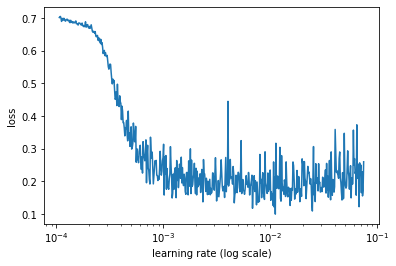

In [339]:
# Plot the loss, ignore 5 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=5, n_skip_end=5)

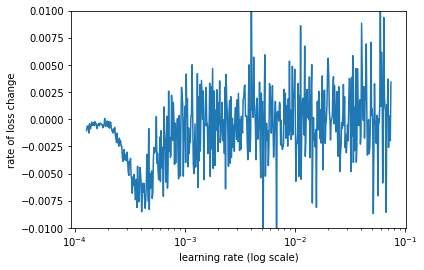

In [340]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.01, 0.01))


In [0]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

      
        for k, v in logs.items():
          self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

   


In [536]:
iterations = len(train_y)/512
step_size = math.floor(iterations*2)
step_size

150

### The model is not deterministic because of dropout so results may vary

In [0]:
clr = CyclicLR(base_lr=0.001, max_lr=0.03,step_size=step_size)
early_stop = EarlyStopping(monitor='val_loss', patience = 1, verbose = 1) 
checkpoint = ModelCheckpoint('attention.h5',monitor='val_loss', verbose=1, save_best_only=True)

In [610]:
history = model.fit(train_X, train_y,validation_data=(val_X, val_y),callbacks=[clr,early_stop,checkpoint],batch_size=512,verbose=1,epochs=4)

Train on 38430 samples, validate on 4271 samples
Epoch 1/4
38430/38430 [==============================] - 57s 1ms/step - loss: 0.3222 - accuracy: 0.8537 - val_loss: 0.1842 - val_accuracy: 0.9274

Epoch 00001: val_loss improved from inf to 0.18422, saving model to attention.h5
Epoch 2/4
38430/38430 [==============================] - 55s 1ms/step - loss: 0.1887 - accuracy: 0.9331 - val_loss: 0.1692 - val_accuracy: 0.9403

Epoch 00002: val_loss improved from 0.18422 to 0.16924, saving model to attention.h5
Epoch 3/4
38430/38430 [==============================] - 55s 1ms/step - loss: 0.1669 - accuracy: 0.9410 - val_loss: 0.1595 - val_accuracy: 0.9431

Epoch 00003: val_loss improved from 0.16924 to 0.15951, saving model to attention.h5
Epoch 4/4
38430/38430 [==============================] - 55s 1ms/step - loss: 0.1359 - accuracy: 0.9517 - val_loss: 0.1559 - val_accuracy: 0.9466

Epoch 00004: val_loss improved from 0.15951 to 0.15589, saving model to attention.h5


In [635]:
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# codes from machinelearningmastery.com
def print_hist(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

   
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


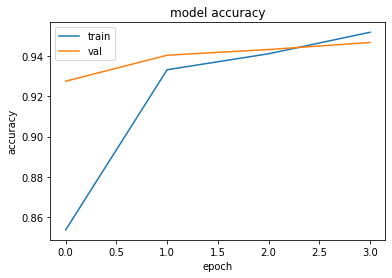

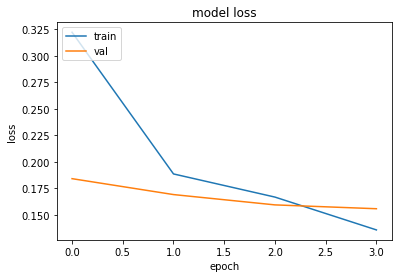

In [637]:
print_hist(history)

In [638]:
pred_glove_train_y = model.predict([train_X], batch_size=1024, verbose=1)
scores = []
thresholds = np.arange(0.1, 0.501, 0.01)
for thresh in thresholds:
    thresh = np.round(thresh, 2)
    scores.append(metrics.f1_score(train_y, (pred_glove_train_y>thresh).astype(int)))
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(train_y, (pred_glove_train_y>thresh).astype(int))))
idx = np.argmax(np.array(scores))
thresh_train = thresholds[idx]

38430/38430 [==============================] - 3s 79us/step
F1 score at threshold 0.1 is 0.9131994051957897
F1 score at threshold 0.11 is 0.9176146358625541
F1 score at threshold 0.12 is 0.921203902956696
F1 score at threshold 0.13 is 0.9242567807651308
F1 score at threshold 0.14 is 0.9274879543156267
F1 score at threshold 0.15 is 0.9298465580034628
F1 score at threshold 0.16 is 0.932434456928839
F1 score at threshold 0.17 is 0.9343631664362565
F1 score at threshold 0.18 is 0.9364897466827503
F1 score at threshold 0.19 is 0.9382275572219031
F1 score at threshold 0.2 is 0.9396648383284343
F1 score at threshold 0.21 is 0.9411157024793388
F1 score at threshold 0.22 is 0.9424307036247335
F1 score at threshold 0.23 is 0.9436542335632746
F1 score at threshold 0.24 is 0.9449473941766577
F1 score at threshold 0.25 is 0.946322920817878
F1 score at threshold 0.26 is 0.94703227193171
F1 score at threshold 0.27 is 0.948278514507246
F1 score at threshold 0.28 is 0.94896449704142
F1 score at thresho

In [639]:
print(thresh_train)


0.4299999999999998


In [640]:
pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
scores = []
thresholds = np.arange(0.1, 0.501, 0.01)
for thresh in thresholds:
    thresh = np.round(thresh, 2)
    scores.append(metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int)))
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))))
idx = np.argmax(np.array(scores))
thresh_valid = thresholds[idx]

4271/4271 [==============================] - 0s 84us/step
F1 score at threshold 0.1 is 0.8925964546402503
F1 score at threshold 0.11 is 0.8981092436974789
F1 score at threshold 0.12 is 0.9020849828450779
F1 score at threshold 0.13 is 0.9048502517890273
F1 score at threshold 0.14 is 0.9066737569795267
F1 score at threshold 0.15 is 0.9090424113096826
F1 score at threshold 0.16 is 0.911134903640257
F1 score at threshold 0.17 is 0.9130434782608695
F1 score at threshold 0.18 is 0.9141781006187787
F1 score at threshold 0.19 is 0.9165991902834008
F1 score at threshold 0.2 is 0.9182015167930662
F1 score at threshold 0.21 is 0.9183618117710877
F1 score at threshold 0.22 is 0.9198151671649905
F1 score at threshold 0.23 is 0.9215258855585831
F1 score at threshold 0.24 is 0.9232030609456137
F1 score at threshold 0.25 is 0.9243835616438357
F1 score at threshold 0.26 is 0.9250205987366108
F1 score at threshold 0.27 is 0.9270575282135977
F1 score at threshold 0.28 is 0.9272326350606395
F1 score at th

In [641]:
print(thresh_valid)


0.47999999999999976


In [642]:
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score

print('total valid data is ',train_y.shape[0], 'where', np.sum(train_y==1),'is toxic' )
print(accuracy_score(train_y, pred_glove_train_y>thresh_train))
confusion_matrix(train_y, pred_glove_train_y>thresh_train, labels=[0, 1])

total valid data is  38430 where 15870 is toxic
0.9633879781420766


array([[21902,   658],
       [  749, 15121]])

In [643]:
print('total valid data is ',val_y.shape[0], 'where', np.sum(val_y==1),'is toxic' )
print(accuracy_score(val_y, pred_glove_val_y>thresh_valid))
confusion_matrix(val_y, pred_glove_val_y>thresh_valid, labels=[0, 1])

total valid data is  4271 where 1764 is toxic
0.9466167173963943


array([[2402,  105],
       [ 123, 1641]])

In [644]:
# result
pred_test = model.predict(test_X)
print('f1 score',f1_score(test_df["class"].values,pred_test>thresh_valid))
print("Confusion matrix")
print(confusion_matrix(test_df["class"].values, pred_test>thresh_valid, labels=[0, 1]))

f1 score 0.940204081632653
Confusion matrix
[[6756  212]
 [ 374 4607]]


## Analysis

In [0]:
def most_false_negative(pred_y,true_y,thresh, N ):
    pred_y_round = (pred_y>thresh)
    
    flag = (pred_y_round == 0) & (true_y == 1)[:,np.newaxis]
    
    idxs = np.where(flag)[0] # ignore the np.newaxis dimension
    newidx = np.argsort(pred_y[idxs,0])

    return idxs[newidx[:N]], pred_y[idxs[newidx[:N]]]

def most_uncertain_negative(pred_y,true_y,thresh, N ):
    pred_y_round = (pred_y>thresh)
    flag = (pred_y_round == 0) & (true_y == 1)[:,np.newaxis]
    
    idxs = np.where(flag)[0] # ignore the np.newaxis dimension
    newidx = np.argsort(pred_y[idxs,0])
    return idxs[newidx[-N:]], pred_y[idxs[newidx[-N:]]]

def most_uncertain_positive(pred_y,true_y,thresh, N ):
    pred_y_round = (pred_y>thresh)
    
    flag = (pred_y_round == 1) & (true_y == 0)[:,np.newaxis]
    
    idxs = np.where(flag)[0] # ignore the np.newaxis dimension
    newidx = np.argsort(pred_y[idxs,0])

    return idxs[newidx[:N]], pred_y[idxs[newidx[:N]]]

def most_false_positive(pred_y,true_y,thresh, N ):
    pred_y_round = (pred_y>thresh)
    flag = (pred_y_round == 1) & (true_y == 0)[:,np.newaxis]
    
    idxs = np.where(flag)[0] # ignore the np.newaxis dimension
    newidx = np.argsort(pred_y[idxs,0])
    return idxs[newidx[-N:]], pred_y[idxs[newidx[-N:]]]

def most_true_positive(pred_y,true_y,thresh, N ):
    pred_y_round = (pred_y>thresh)
    
    flag = (pred_y_round == 1) & (true_y == 1)[:,np.newaxis]
    
    idxs = np.where(flag)[0] # ignore the np.newaxis dimension
    newidx = np.argsort(pred_y[idxs,0])

    return idxs[newidx[-N:]], pred_y[idxs[newidx[-N:]]]




In [646]:
k = 20
idx, prob = most_false_positive( pred_glove_val_y, val_y,thresh_valid,k)
for i in range(k):
    print('class',val_y[idx[i]],prob[i],val_df["tweet"].values[idx[i]])


class 0 [0.98572195] <user> yeah and you are gonna play with retards who wanna do drugs all day but
class 0 [0.98713964] all my friends whores
class 0 [0.9890877] fuck i am such a bitch
class 0 [0.99052715] <user> <user> <user> <user> <user> <user> bitch i am proud to be black
class 0 [0.99158806] <user> <user> <user> <user> thanks to the best b would wknd kickoff friday bitches
class 0 [0.9918664] you wanna find hoes on here ? just follow the chicks who reply with heart eyes under sex gifs
class 0 [0.9918922] yeah it was a great one actually i am fucking hilarious bitches
class 0 [0.99206513] <user> if you are a bad bitch why are you wearing sneakers ?
class 0 [0.9937356] <user> <user> them hoes are clean !
class 0 [0.99397624] <user> hope you dont all get shot you horrible hateful cunts there is no god you do all this crap in the name of hate
class 0 [0.99533135] <user> they be pussy pressed ! !
class 0 [0.9962006] <user> never go full retard
class 0 [0.9967012] niggas gossip like bi

In [648]:
idx, prob = most_false_negative( pred_glove_val_y, val_y,thresh_valid,k)
for i in range(k):
    print('class',val_y[idx[i]],prob[i],val_df["tweet"].values[idx[i]])


class 1 [0.0018226] <user> thanks walking dead bro steve for mend usmc <allcaps> come on you sonnbitches you want to live forever ! dog
class 1 [0.00237805] <user> funny <user> cannot get rid of <hashtag> <hashtag> stammendment so many distractions and lousy qb maybe next year probab
class 1 [0.00287248] this obviously <hashtag> tcot gets on & <hashtag> inaspanof maybe <hashtag> allof two seconds after boarding thinks he knows what
class 1 [0.00328062] <hashtag> whitepeople ? all cou no media coverage or wp were victims and feared for their lives maybe probation <hashtag> blackperson who ? ?
class 1 [0.00382859] <user> dealing with relatives reminding you that the clock is ticking ? this might help <hashtag> childfree
class 1 [0.00460764] <user> the real jeff sessions <hashtag> neverump <hashtag> swampmonster
class 1 [0.0053173] this will absolutely piss you off <hashtag> replacyclay <hashtag> maga
class 1 [0.00579123] <user> <user> lock the gate ! <hashtag> pamgelleheracist <hashtag> 

In [649]:
idx, prob = most_uncertain_positive( pred_glove_val_y, val_y,thresh_valid,k)
for i in range(k):
    print('class',val_y[idx[i]],prob[i],val_df["tweet"].values[idx[i]])



class 0 [0.4809584] what a massive disappointment <user> is supposing a racist mysogonist liar like <user> unfollow and dislike
class 0 [0.48419017] <user> <hashtag> manilow originally wrote the song with this title after a rewrite the big hit came with mandy <hashtag> yourewelcome how am i ?
class 0 [0.48770252] <user> outdrawn and outgunned by fucking <hashtag> rinsepubis weak dude
class 0 [0.48800063] b c she likes black men and rap music ? huh laughing out loud <user> <user> in general she wants to be colored
class 0 [0.48976988] <user> did you make an animal cracker taco
class 0 [0.49041927] <user> i assume so the tranny went out this morning i have a maxima
class 0 [0.4984969] <hashtag> orlando agreed it is worst for humanity <hashtag> pakistanis please tell how many of you condemn the open murders of women in pakistan daily
class 0 [0.5105978] is that an albino mexican ? no dad he is asian
class 0 [0.5114656] we gotta stay humble sy sike who i am kidding fuck it !
class 0 [0.515

In [650]:
idx, prob = most_uncertain_negative( pred_glove_val_y, val_y,thresh_valid,k)
for i in range(k):
    print('class',val_y[idx[i]],prob[i],val_df["tweet"].values[idx[i]])

class 1 [0.37672934] <user> <hashtag> allahsoil enlightenment is wasted on the wilfully blind <hashtag> emiratis
class 1 [0.38674602] <user> <hashtag> allahsoil there have been three stages of empire imperialism colonialism and neocolonialism
class 1 [0.38695654] <user> a girl tweeted you might be ghetto if you bring food from outside into the movies no you might be stupid if you pay for a b
class 1 [0.39514974] a bird just smacked right into my car window my parked car window scared the fuck outta me
class 1 [0.41519356] <user> <user> i am defending a woman against condescension although i saw you tweet that she belongs in the kitchen
class 1 [0.4172173] reject news my latest <hashtag> amwriting article on <user>
class 1 [0.42070106] you are ugly go die
class 1 [0.42084998] <user> <user> if ur employees r going to say merry christmas to white people please teach them to say it to the brown people too
class 1 [0.42346004] <user> barack <hashtag> obama gets real about the he <hashtag> f

In [0]:
def predict_result(text):
  val = tokenizer.texts_to_sequences([text])
  val = pad_sequences(val, maxlen=maxlen,padding='post',truncating='post')
  return model.predict(val)[0]

In [611]:
predict_result("That is fucking good")

array([0.17055526], dtype=float32)

In [612]:
predict_result("you are so fucking annoying shut up ")

array([0.89436674], dtype=float32)

In [651]:
#hate vs profanity paper example 
predict_result(" holy shit ! look at those fucking  prices")

array([0.22065535], dtype=float32)

In [614]:
predict_result("what the fuck")

array([0.4830824], dtype=float32)

In [617]:
predict_result("killing the game dude")

array([0.26800358], dtype=float32)

In [618]:
predict_result("fuck you")

array([0.66526496], dtype=float32)

In [619]:
predict_result("ban all  muslims")

array([0.6749241], dtype=float32)

In [620]:

predict_result("ban  all black people")

array([0.5381992], dtype=float32)

In [621]:
predict_result("black people are humans too")

array([0.08577669], dtype=float32)

In [622]:
predict_result("stop shooting black people <hashtag> black lives matter")

array([0.23509276], dtype=float32)

In [658]:
predict_result("<user> everyone hates you go kill yourself")

array([0.6873951], dtype=float32)

In [631]:
predict_result("do not kill yourself")

array([0.18805744], dtype=float32)

In [624]:
predict_result("ban all drugs")


array([0.2789877], dtype=float32)

In [659]:
predict_result("you are so fat you look like a pig")

array([0.4688452], dtype=float32)